In [1]:
%matplotlib notebook

import numpy as np
import cv2
import os
import sys

sys.path.append('../functions/')
sys.path.append('../utils/')

from DoG import DoG
from file_manager import File_manager
from wdd_decoder_functions import create_diff_images, calculate_image_sum_for_frame, calculate_image_sum_for_angle


from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [95]:
test = np.zeros(shape=(50, 50))

test_cov = 30 * np.eye(2)
test_cov[1][1] = test_cov[1][1] * 2

radi = np.pi / 180
a = 0

rot = np.array([[np.cos(a * radi), -np.sin(a * radi)],[np.sin(a * radi), np.cos(a * radi)]])

print(rot)

test_cov = np.transpose(rot) @ test_cov @ rot

print(test_cov)

for x in range(50):
    for y in range(50):
        test[y,x] = multivariate_normal.pdf([x, y], mean=(25, 25), cov=test_cov)


[[ 1. -0.]
 [ 0.  1.]]
[[ 30.   0.]
 [  0.  60.]]


<IPython.core.display.Javascript object>


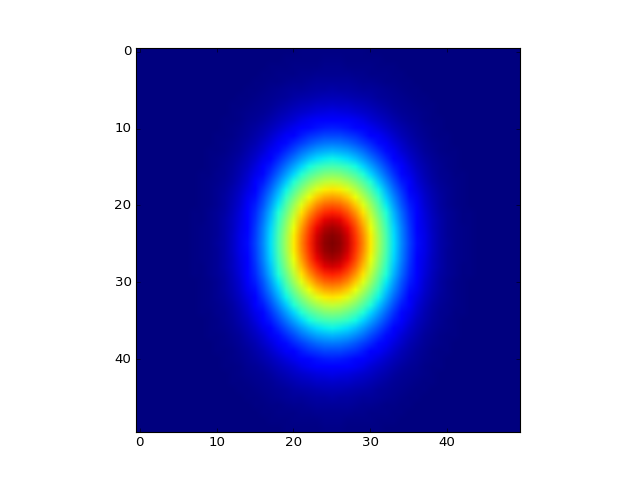

<function matplotlib.pyplot.show>

In [96]:
plt.figure()
plt.imshow(test)
plt.show

In [99]:
moment = cv2.moments(test)
img_cov = np.array([[moment['mu20'], moment['mu11']], [moment['mu11'], moment['mu02']]])
print(img_cov.astype(int))
w, v = np.linalg.eig(img_cov)
print(np.arctan2(v[np.argmin(w)][1], v[np.argmin(w)][0])/radi)
print(v)

[[29  0]
 [ 0 59]]
180.0
[[ -1.00000000e+00   3.90526363e-15]
 [ -3.90526363e-15  -1.00000000e+00]]


<IPython.core.display.Javascript object>


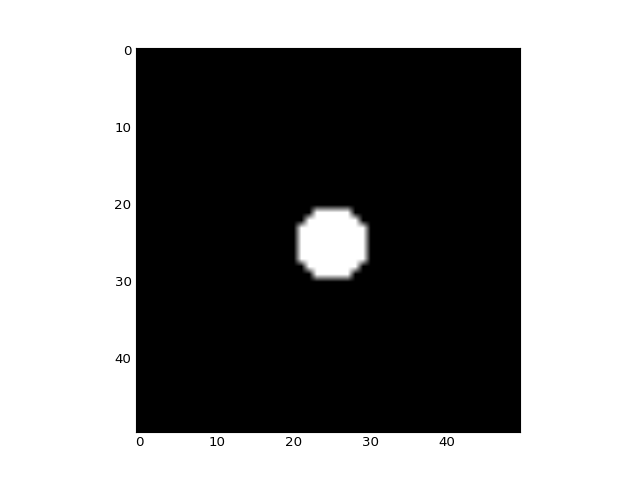

<function matplotlib.pyplot.show>

In [31]:
circle = np.zeros(shape=(50,50))
xx, yy = np.mgrid[:50, :50]

circle = (xx - 25) ** 2 + (yy - 25) ** 2

donut = np.logical_and(circle < (25), circle >= (0))

plt.figure()
plt.imshow(donut,cmap=plt.cm.gray)
plt.show

In [13]:
%load_ext line_profiler

In [14]:
maxima = []
mean_val = []

cov_matrix = np.matrix([[6., 0],[0, 2.]])

smothing = np.matrix([[1,1,1],[1,1,1],[1,1,1]]) / 9

path = '/home/sascwitt/Projects/test/WDs/'
folders = os.listdir(path)
folders.sort()

<IPython.core.display.Javascript object>


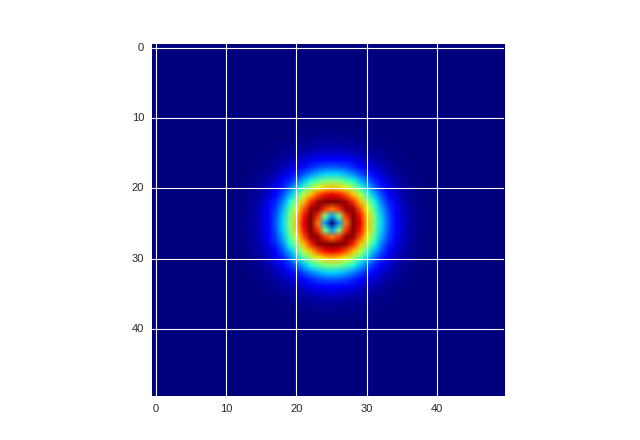

In [189]:
dog = DoG().mexican_head_kernel

cov1 = 30 * np.eye(2)
cov2 = 4 * np.eye(2)

_dog = abs(np.fft.fftshift(np.fft.fft2(dog(50, [25,25], cov1, [25,25], cov2))))

plt.figure()
plt.imshow(_dog, cmap=plt.cm.jet)
plt.show()

In [16]:
fm_csv = File_manager("/home/sascwitt/Projects/test/WDs/").read_csv

In [17]:
diff_img = create_diff_images(path, folders)

In [157]:
fft_imgs = []
keys = []

for key, img_arrays in list(diff_img.items()):
    keys.append(key)
    image = None
    
    for img in img_arrays:
        tmp = np.fft.fftshift(abs(np.fft.fft2(img)))
        if image is None:
            image = tmp
        
        else:
            image += tmp
    
    fft_imgs.append(image)

<IPython.core.display.Javascript object>


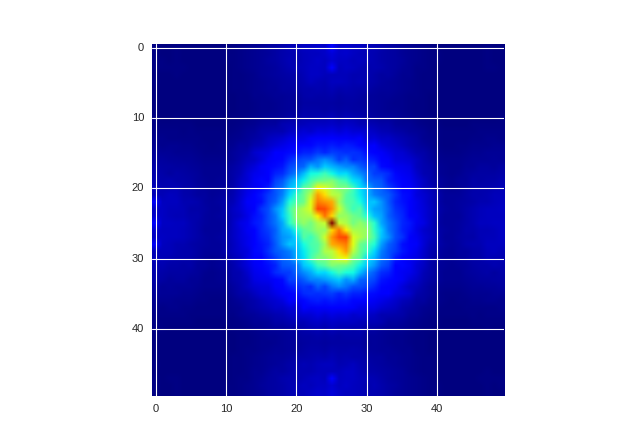

In [190]:
plt.figure()
plt.imshow(fft_imgs[0], cmap=plt.cm.jet)
plt.show()

<IPython.core.display.Javascript object>


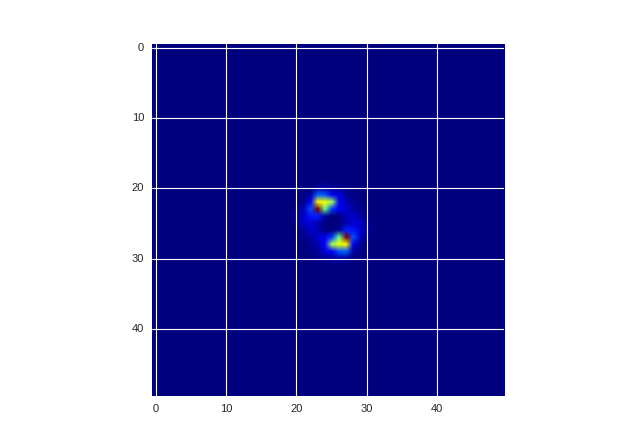

In [195]:
plt.figure()
plt.imshow(np.power(np.multiply(fft_imgs[0], _dog), 5), cmap=plt.cm.jet)
plt.show()

<IPython.core.display.Javascript object>


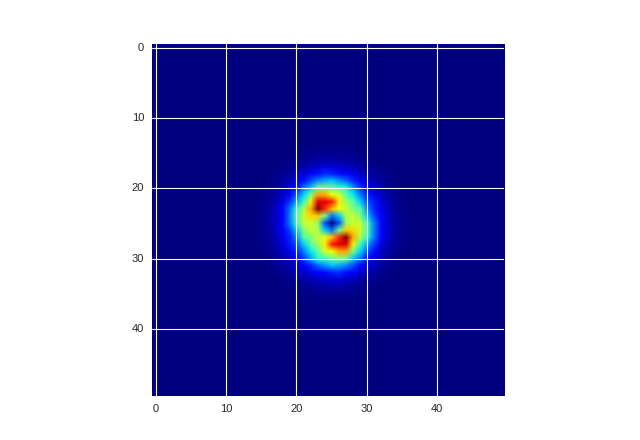

In [194]:
plt.figure()
plt.imshow(np.multiply(fft_imgs[0], _dog), cmap=plt.cm.jet)
plt.show()

In [22]:
def img_moments(image, p, q):
    height, width = image.shape
    center_x = width / 2
    center_y = height / 2
    
    x = np.arange(0, width)
    y = np.arange(0, height)

    X = np.power((x - center_x), p)[np.newaxis]
    Y = np.power((y - center_y), q)[np.newaxis]
    
    t1 = X * Y.T
    
    return sum(sum(np.multiply(t1, image)))

In [23]:
def get_img_cov(image):
    m00 = img_moments(image, 0, 0)
    m11_ = img_moments(image, 1, 1) / m00
    m02_ = img_moments(image, 0, 2) / m00
    m20_ = img_moments(image, 2, 0) / m00
    
    img_cov = np.array([[m20_, m11_], [m11_,m02_]])

    #w,v = np.linalg.eig(img_cov)

    return img_cov

In [49]:
from sklearn.decomposition import PCA

In [152]:
error = []

for index, image in enumerate(fft_imgs):
    dog_filtered = np.multiply(image, _dog)
    
    powered_dog = np.power(dog_filtered, 5)
    
    img_cov = get_img_cov(powered_dog)
    
    w, v = np.linalg.eig(img_cov)
    
    calc_angle = np.arctan2(v[np.argmin(w)][1], v[np.argmin(w)][0])/radi
    
    
    gt_angle = float(fm_csv(keys[index] + "result.csv")["Angle"])
    
    error.append(calc_angle - gt_angle)

In [153]:
for idx, i in enumerate(error):
    if i > 180:
        error[idx] = i - 360
    
    if i < -180:
        error[idx] = i + 360
        
    if error[idx] > 90:
        error[idx] -= 180
        
    if error[idx] < -90:
        error[idx] += 180

In [154]:
import seaborn as sns

<IPython.core.display.Javascript object>


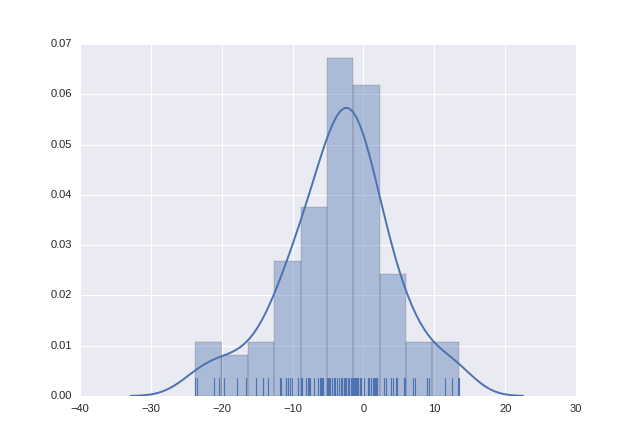

In [155]:
plt.figure() 
sns.distplot(error, rug=True)
plt.show()

In [156]:
print(np.median(error))
print(np.std(error))

-2.88550593722
7.597212169


(1, 50)
(50, 50)
(1, 50)
(50, 50)
(1, 50)
(50, 50)
(1, 50)
(50, 50)
[[  2.99965693e+01   3.84384718e-07]
 [  3.84384718e-07   5.91449254e+01]]
